In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}


feature_names_remained = ['mol_num_cycles', 'FPSA3', 'nO','mol_weight','nHRing',
                 'WPSA5', 'PBF', 'f_to_fg', 'angle_R1X1R2', 'angle_X2X1R1', 
                 'RPCS', 'nARing', 'PPSA5', 'nF', 'identificator', 'mol_volume',
                 'nC', 'chirality', 'TASA', 'f_freedom']
feature_names_remained.append('logP')

In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25


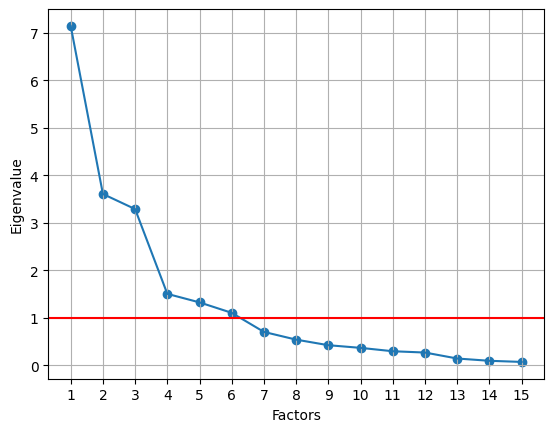

In [3]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

try:
    df_features = merged_dataframe[feature_names_remained]
except:
    df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, len(ev[:15])+1), ev[:15])
plt.plot(range(1, len(ev[:15])+1), ev[:15])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(ev[:15])+1))
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler

n_factors = 6

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5
mol_num_cycles,0.292540,0.007457,0.043611,0.922952,0.128198,0.070867
FPSA3,-0.421962,-0.120582,-0.816641,-0.126649,0.069555,0.072918
nO,-0.047319,-0.040525,-0.059764,0.377058,0.170772,0.569106
mol_weight,0.533327,0.396289,0.496184,0.184856,-0.211232,0.348796
nHRing,0.025536,0.055587,-0.015531,0.442175,0.878015,0.157394
WPSA5,0.519678,0.276729,0.317983,-0.073808,-0.331831,0.646839
PBF,0.668320,0.062431,0.170751,0.122926,-0.072449,-0.021787
f_to_fg,0.108760,0.877846,0.165376,-0.064633,0.107810,0.100527
angle_R1X1R2,0.010952,0.889649,0.156099,0.082576,0.077391,0.049008
angle_X2X1R1,0.023481,0.922603,0.169759,0.090579,0.101283,0.055010


In [26]:
df_features

,mol_num_cycles,FPSA3,nO,mol_weight,nHRing,WPSA5,PBF,f_to_fg,angle_R1X1R2,angle_X2X1R1,...,nARing,PPSA5,nF,identificator,mol_volume,nC,chirality,TASA,f_freedom,logP
1,2,0.033183,1,128.171,0,6.805737,0.480830,0.0,0.000000,0.000000,...,1,16.178954,0,0,204.232,13,0,386.217003,1,2.88
2,3,0.029652,1,126.155,0,6.398578,0.482852,0.0,0.000000,0.000000,...,2,15.488153,0,0,196.656,13,3,374.392938,1,2.87
3,3,0.032625,1,126.155,0,6.565329,0.661986,0.0,0.000000,0.000000,...,2,15.945793,0,0,196.648,13,3,380.778852,1,2.92
4,3,0.030749,1,162.136,0,7.112882,0.568649,2.0,103.610503,111.876204,...,2,16.472886,2,0,205.768,13,3,315.350612,0,2.37
5,3,0.031254,1,162.136,0,7.182593,0.509265,2.0,178.389040,171.049596,...,2,16.751082,2,0,207.800,13,3,315.523351,0,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,1,0.041958,1,63.075,0,5.829352,0.372703,1.0,0.000000,0.000000,...,0,16.417926,1,1,154.224,9,0,270.323674,1,1.07
103,2,0.032826,1,121.131,0,7.576662,0.637438,1.0,0.000000,0.000000,...,1,18.645909,2,1,200.976,12,0,321.823571,1,2.48
49,2,0.030806,1,100.117,0,5.590639,0.453419,0.0,0.000000,0.000000,...,1,14.530611,0,0,174.064,11,2,342.157591,1,2.42
22,2,0.026624,1,164.152,0,6.805890,0.600066,2.0,102.125934,110.671194,...,1,15.631646,2,0,212.928,13,1,327.192745,0,2.72


In [4]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.517652103968506

In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: 6113.420951765866, p-value: 0.0


In [6]:
from sklearn.preprocessing import StandardScaler

n_factors = 4

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3
mol_num_cycles,-0.039155,0.133412,0.860257,-0.117045
FPSA3,-0.241556,-0.888960,-0.117637,-0.063568
nO,0.067666,-0.205008,0.443055,0.142616
mol_weight,0.459288,0.567448,0.392342,0.464932
nHRing,0.199306,-0.126200,0.575971,-0.557325
WPSA5,0.359782,0.372657,0.269441,0.762306
PBF,0.014841,0.495969,0.376485,0.141036
f_to_fg,0.880361,0.078499,0.075867,0.026541
angle_R1X1R2,0.862408,0.027997,0.118057,-0.018688
angle_X2X1R1,0.900434,0.038297,0.137358,-0.030428


Kruskal for f_to_fg: 16.55
P-value: 0.0054
There is a statistically significant difference between the groups
R^2 score: 0.11449287791547469
{'mse': 757.224, 'mae': 22.941, 'r_score': 0.114}
R^2 score: 0.25710357026862957
{'mse': 347.731, 'mae': 15.24, 'r_score': 0.257}
Kruskal for nF: 26.90
P-value: 0.0000
There is a statistically significant difference between the groups
['f_to_fg', 'angle_R1X1R2', 'angle_X2X1R1', 'nF']
R^2 score: 0.3316989826136607
{'mse': 0.0, 'mae': 0.002, 'r_score': 0.332}
R^2 score: 0.32906312917450203
{'mse': 605.547, 'mae': 19.291, 'r_score': 0.329}
R^2 score: 0.19077290014208123
{'mse': 201.3, 'mae': 12.097, 'r_score': 0.191}
R^2 score: 0.2536397889641837
{'mse': 275.017, 'mae': 12.69, 'r_score': 0.254}
R^2 score: 0.3348636575053369
{'mse': 1064.575, 'mae': 26.987, 'r_score': 0.335}
Mann-Whitney U for f_freedom: 5210.50
P-value: 0.0000
There is a statistically significant difference between the groups
['FPSA3', 'mol_weight', 'RPCS', 'mol_volume', 'TASA', 'f_f

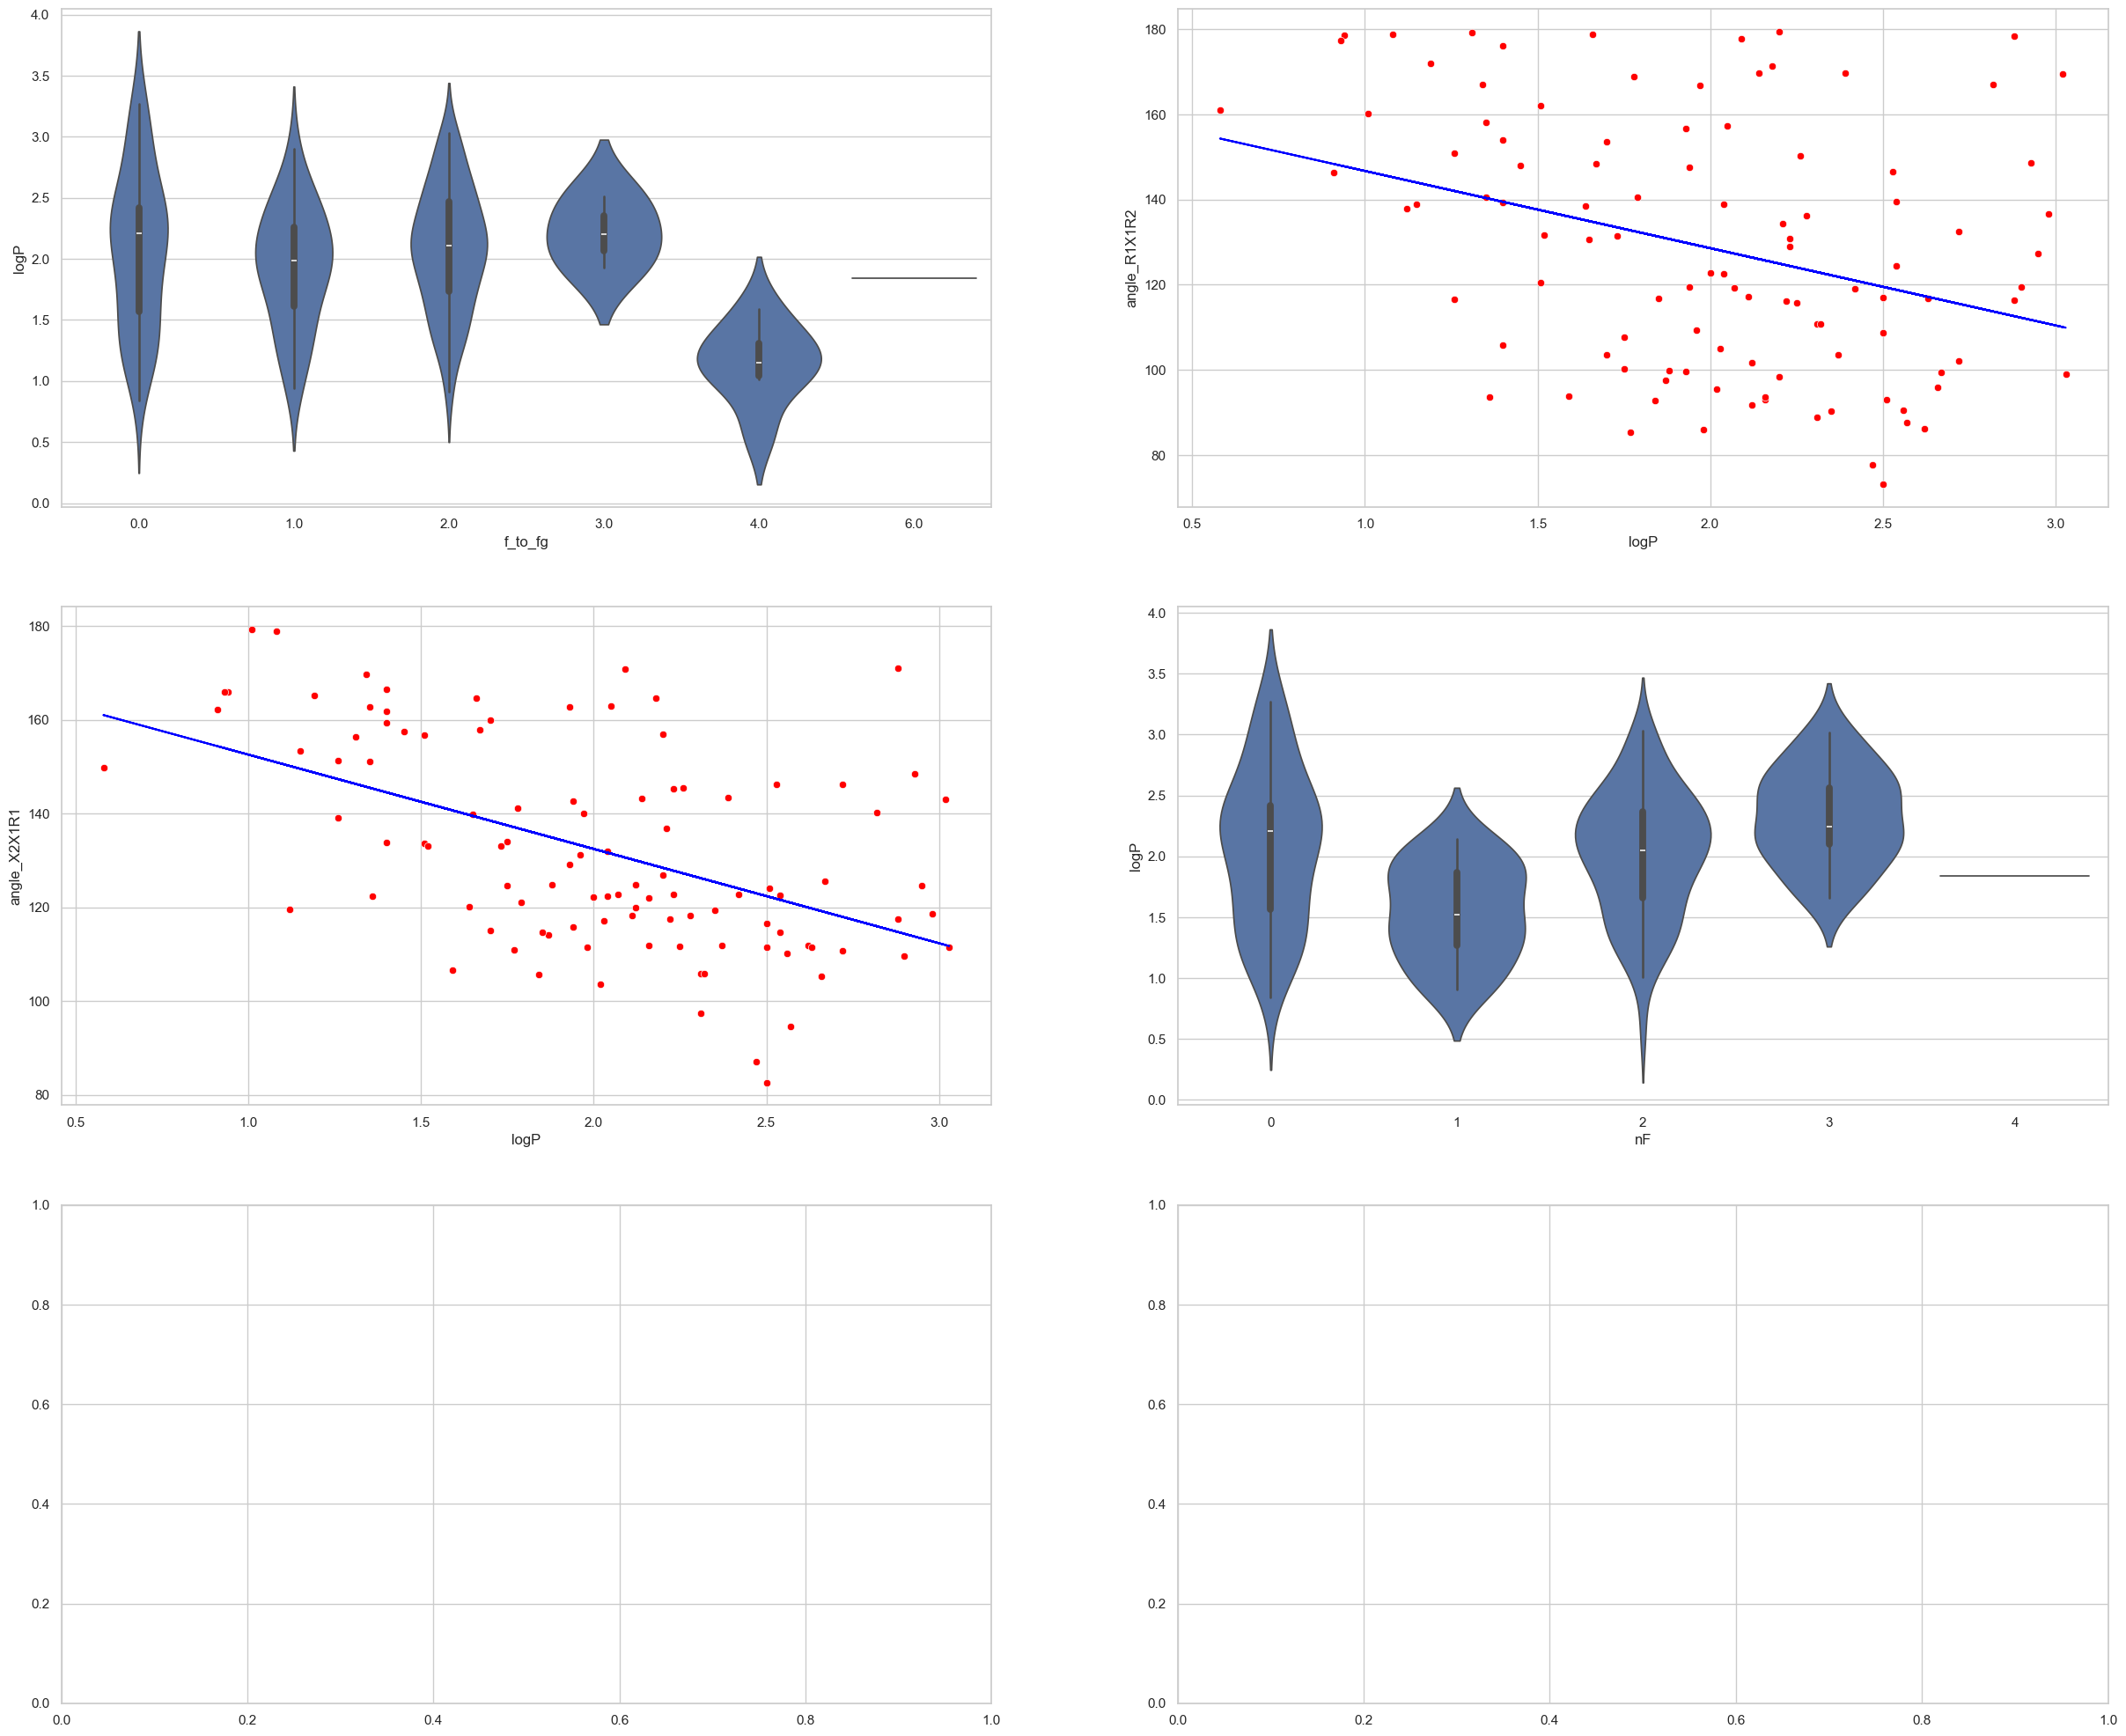

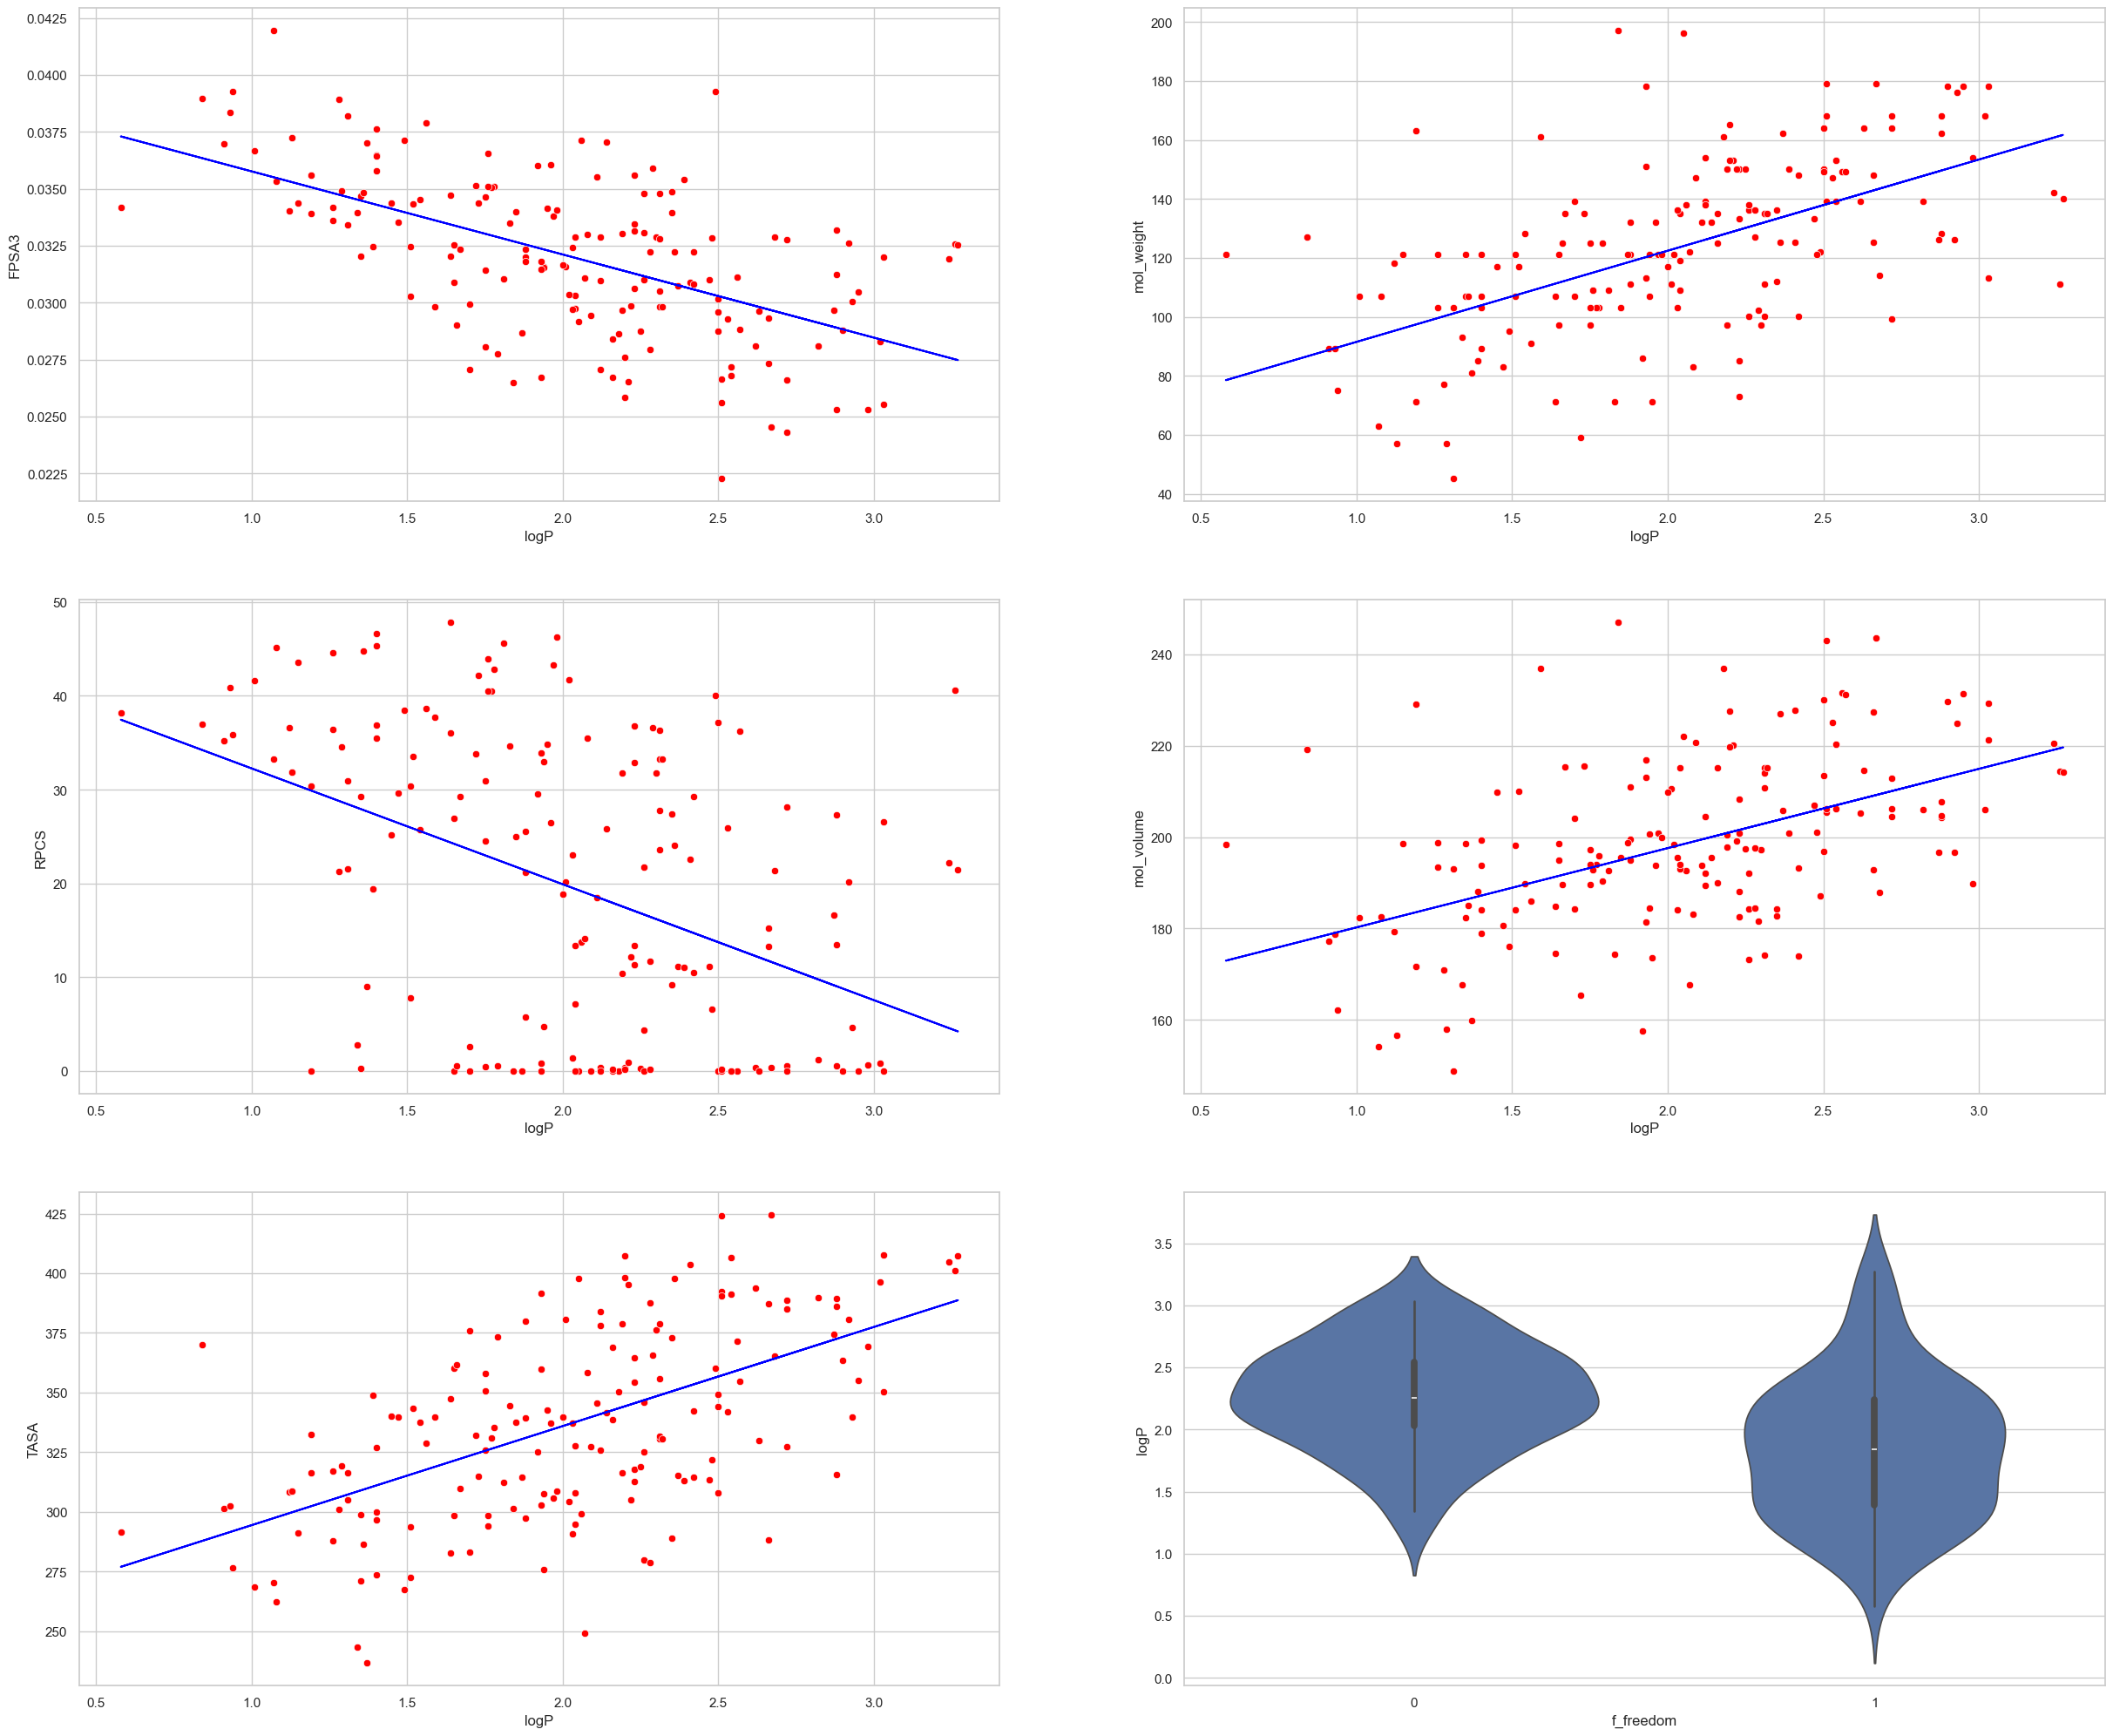

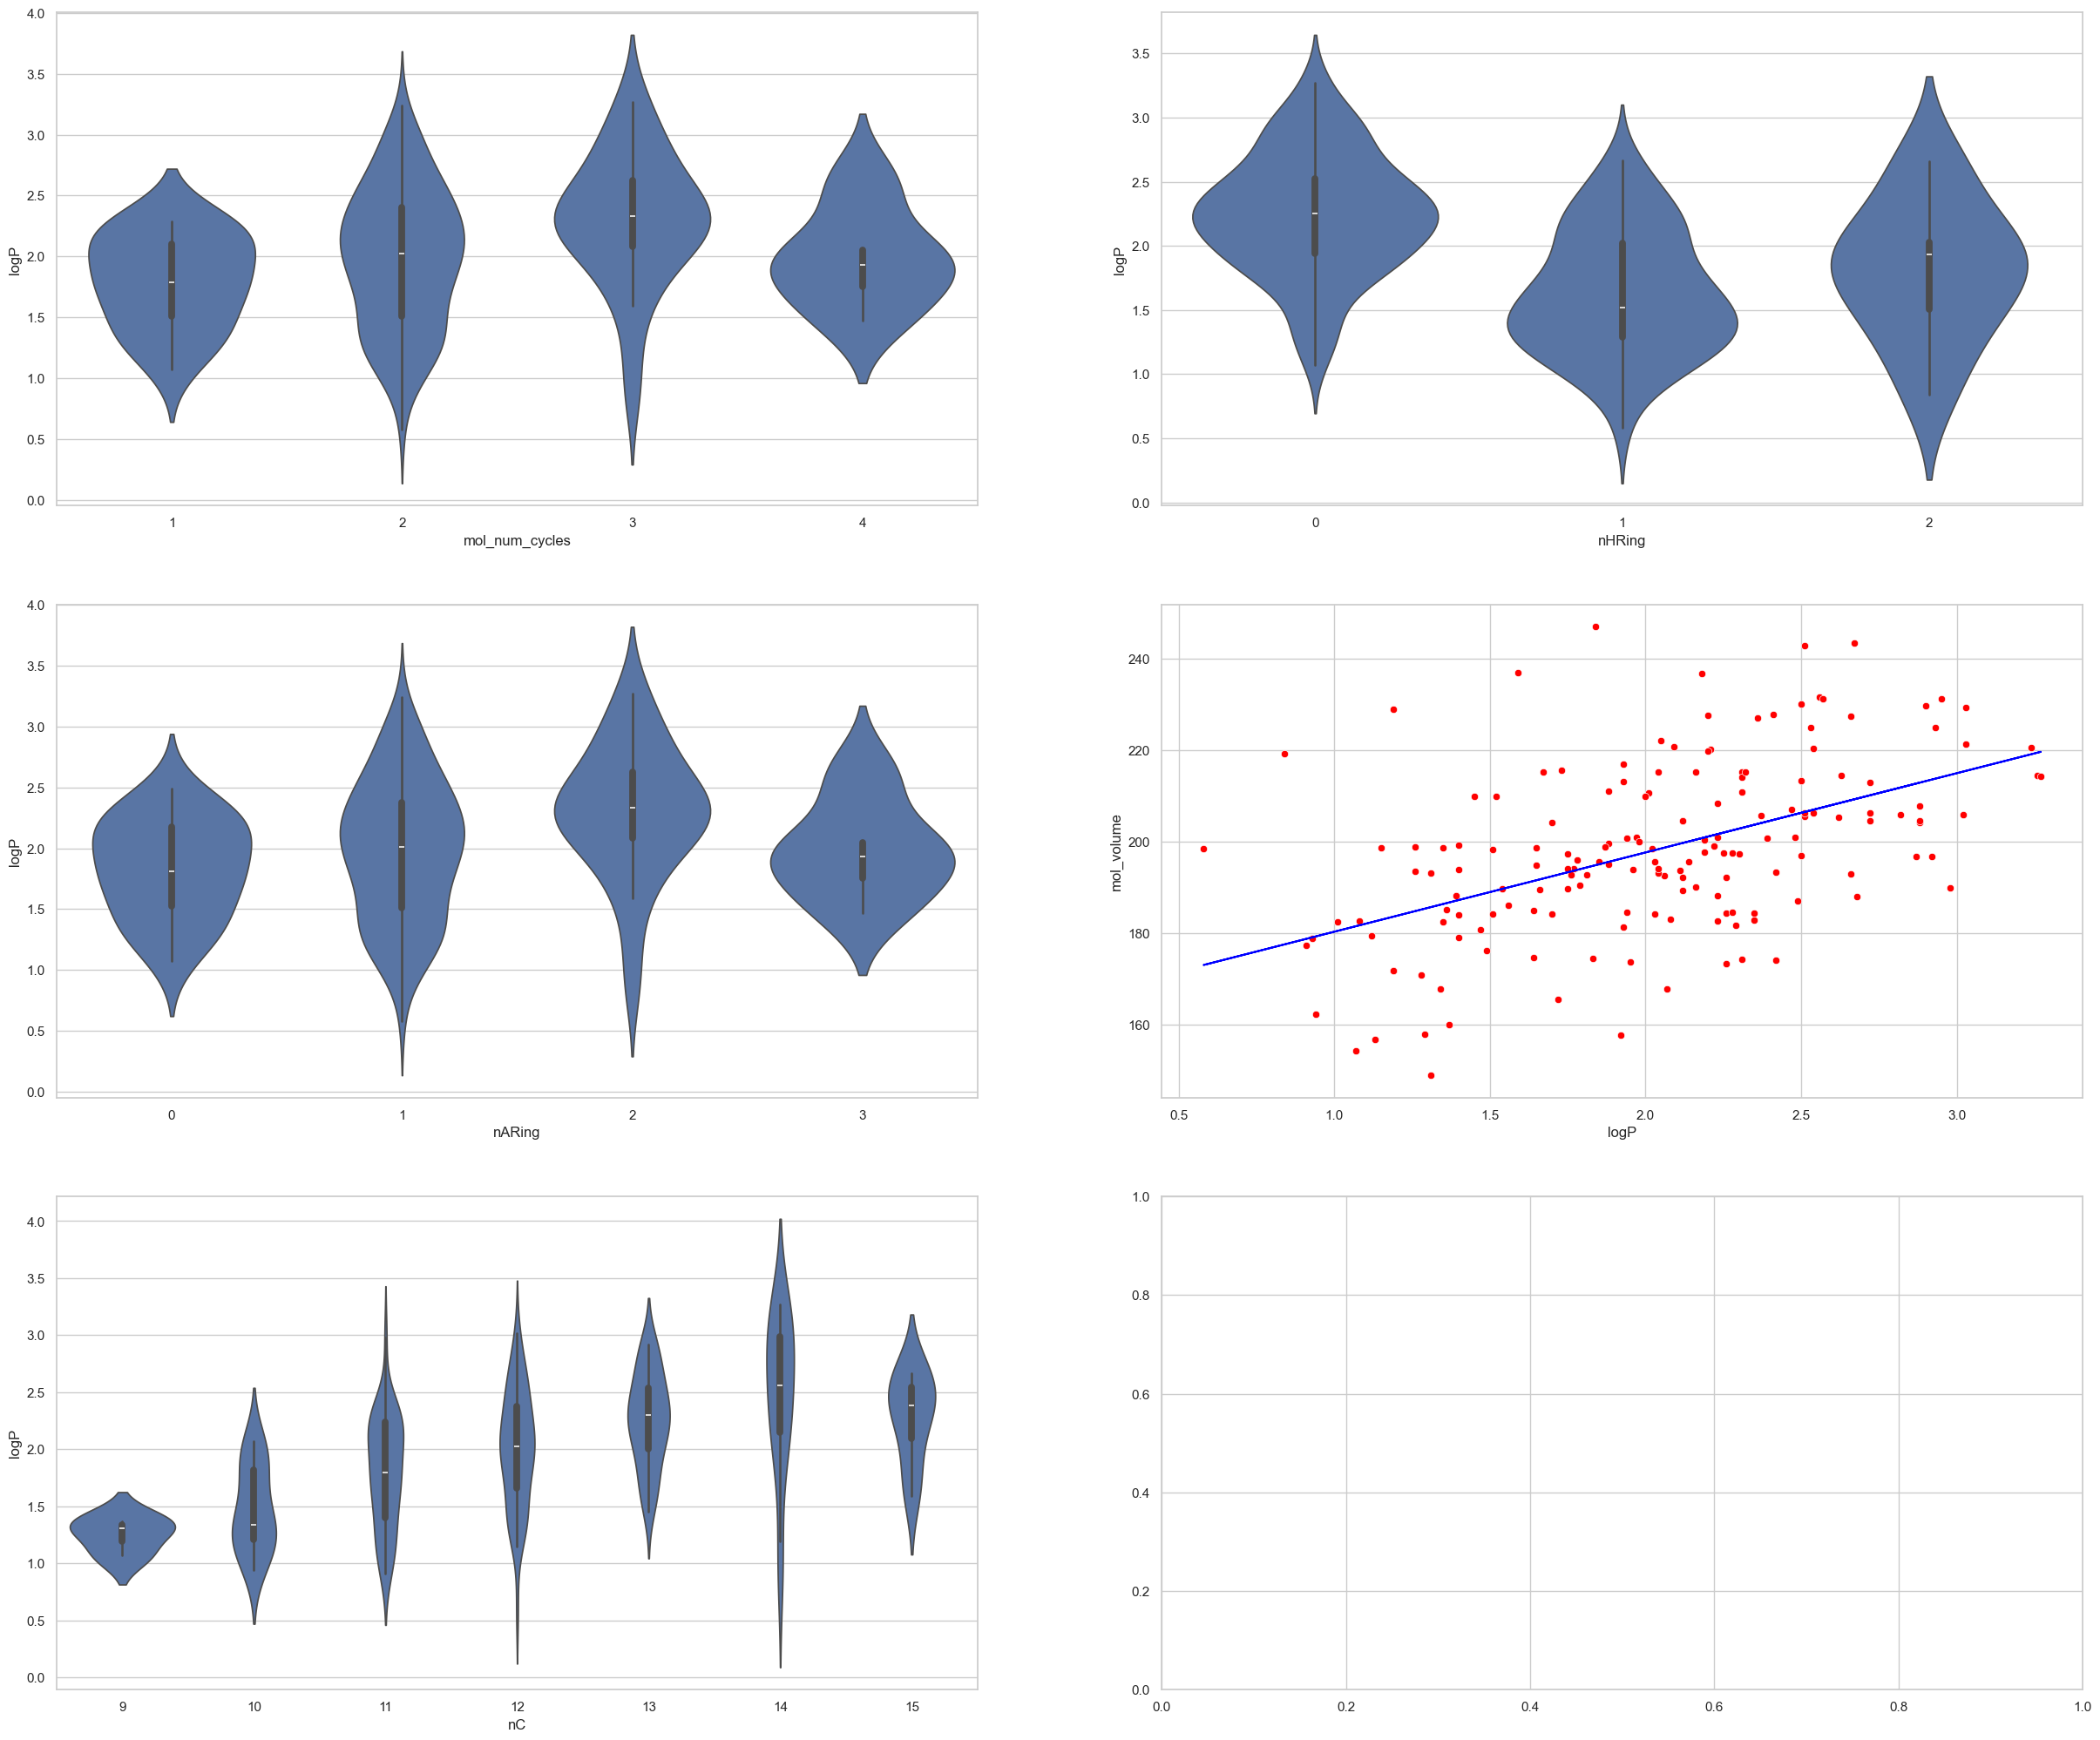

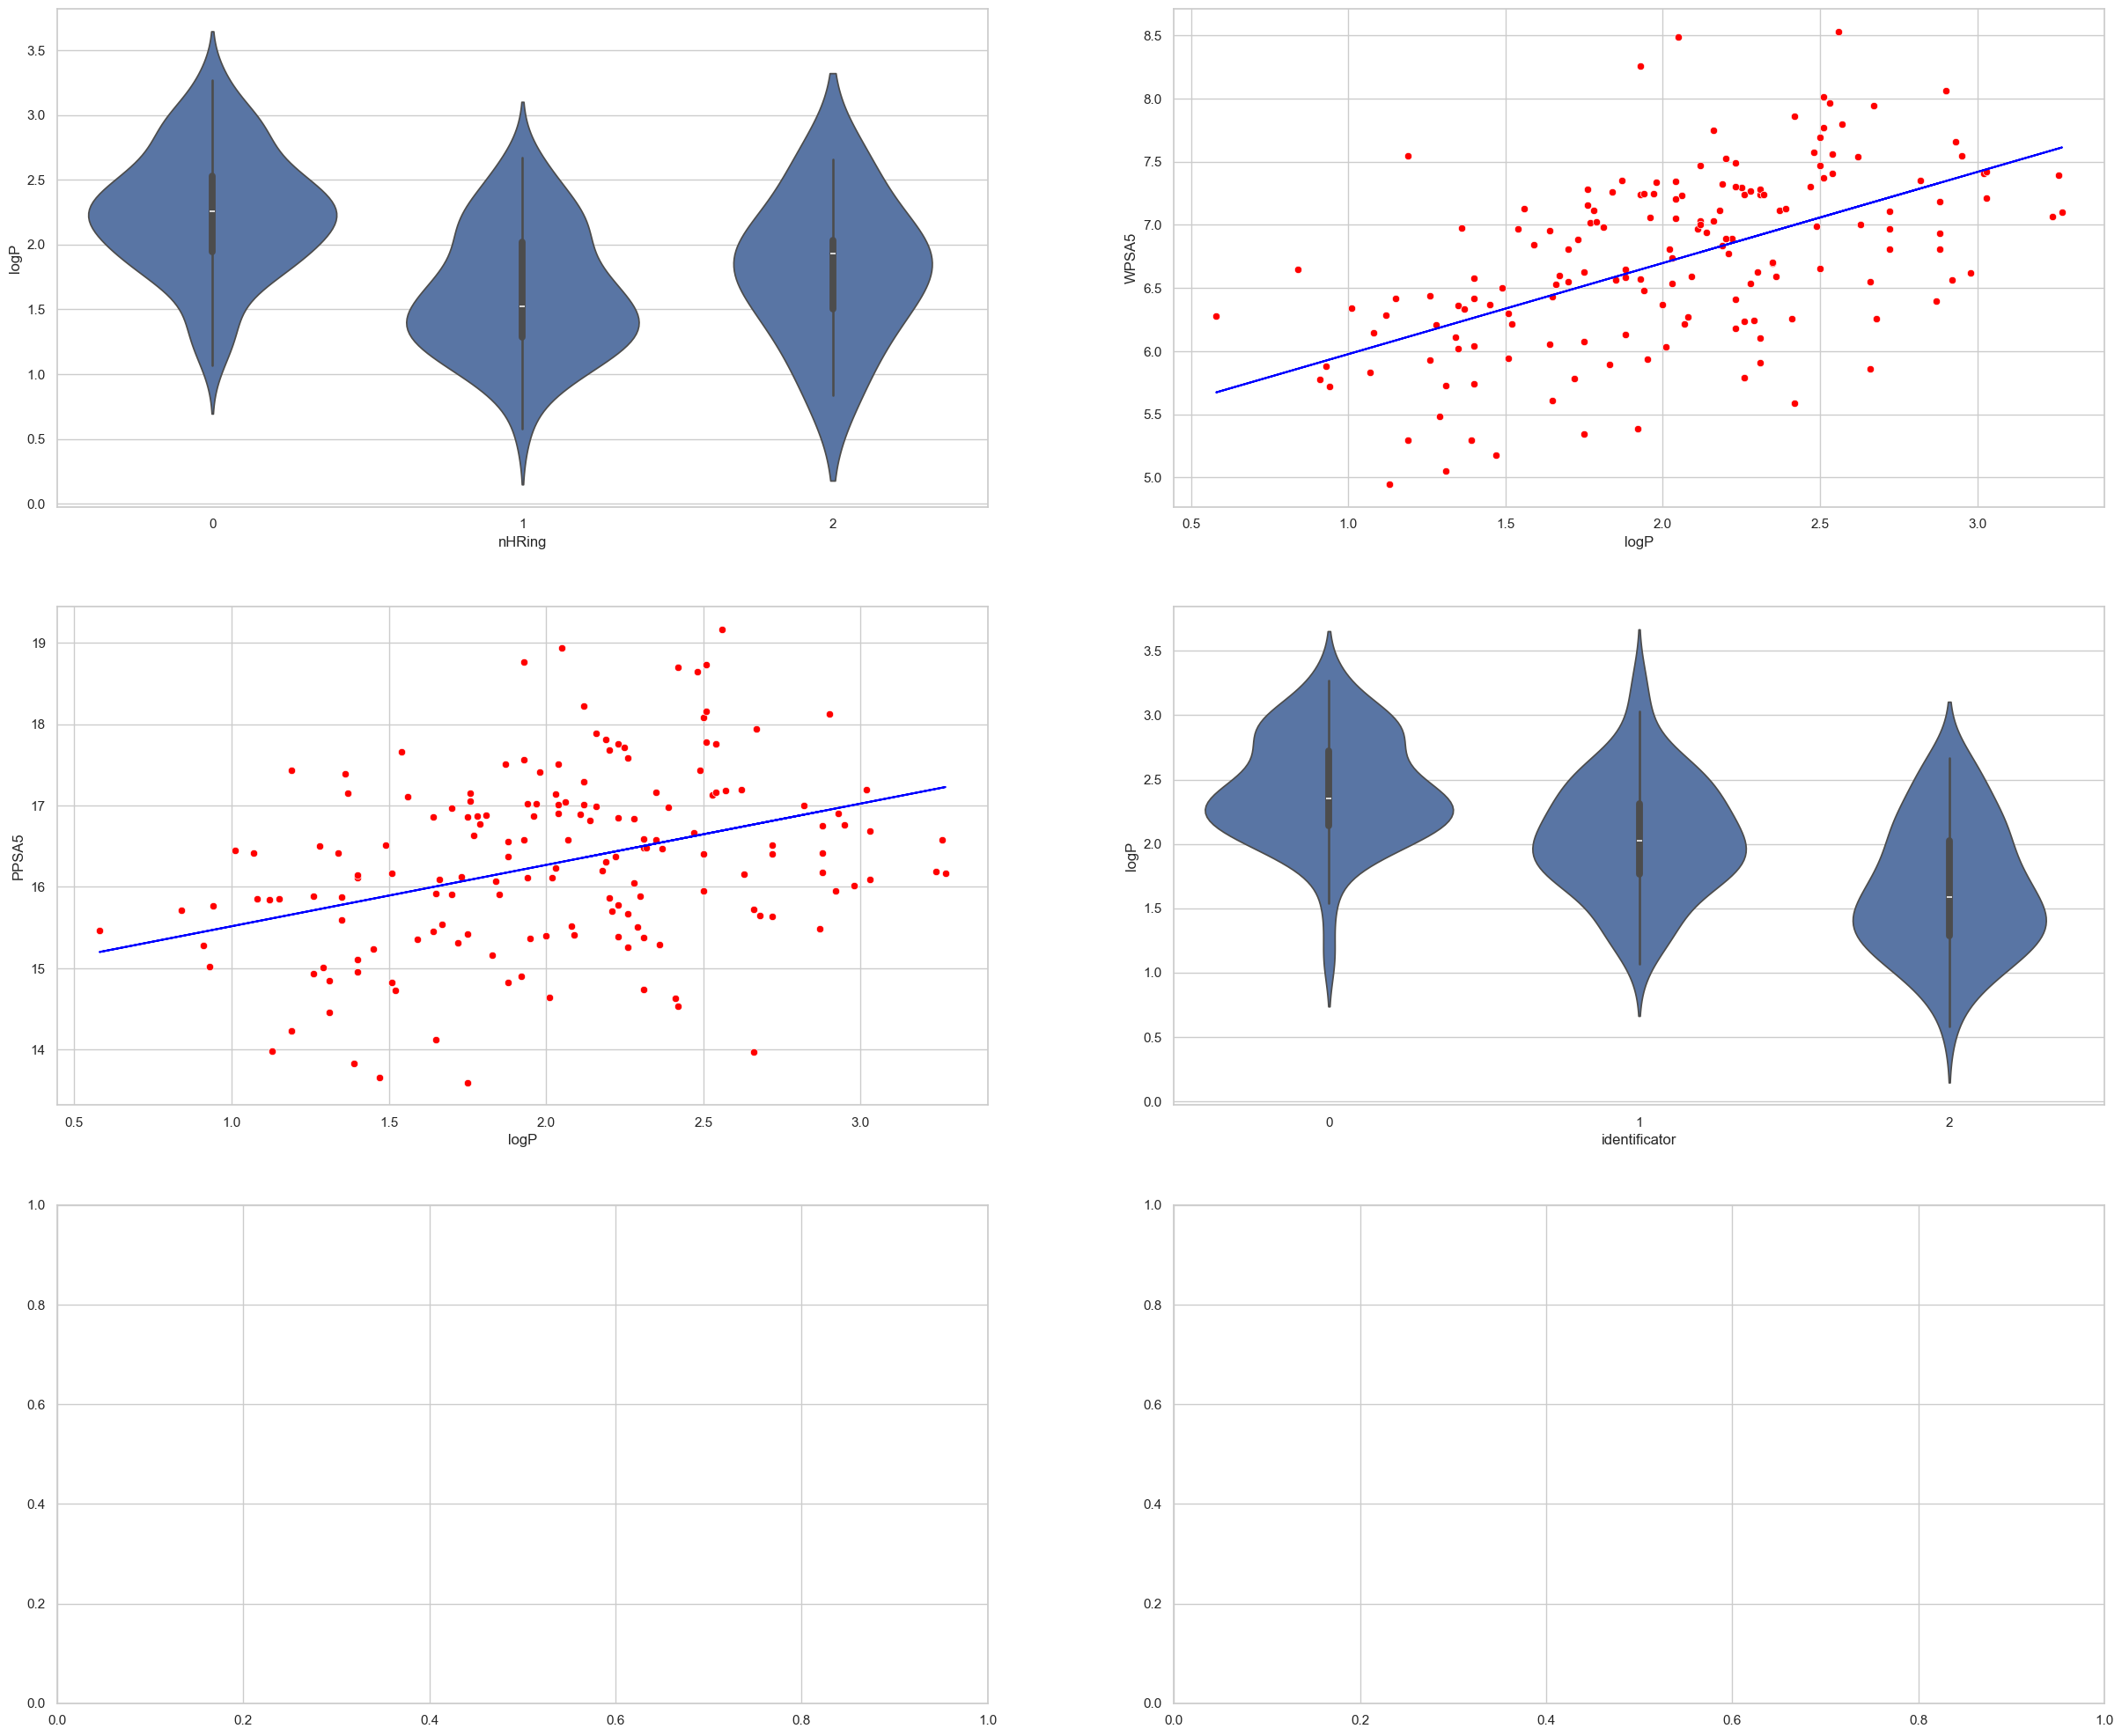

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

target_name = "logP"

n_rows = 3
n_columns = 2

for factor_index in fa_load.keys():
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(30, 25))
    factor_top_features = []
    ax_index = 0
    for feature_name in fa_load[factor_index].keys():
        if abs(fa_load[factor_index][feature_name]) > 0.5 and feature_name != target_name:
            factor_top_features.append(feature_name)

            _x = list(df_features['logP'])
            _y = list(df_features[feature_name])
            x, y = [], []
            for index in range(len(_x)):
                if _y[index] == 0 and ("angle" in feature_name or "distance" in feature_name):
                    continue
                else:
                    x.append(_x[index])
                    y.append(_y[index])

            if len(set(y)) > 15:
                slope, intercept, r, p, se = linregress(x, y)
                y_line = [slope * xi + intercept for xi in x]

                r_2 = pow(r, 2)
                if r_2 > 0.1:
                    remained_features.add(feature_name)
                    
                print(f"R^2 score: {r_2}")
                print(calculate_metrics(y, y_line))

                sns.scatterplot(x=x, y=y, ax=axs[ax_index // n_columns, ax_index % n_columns], color="red")
                axs[ax_index // n_columns, ax_index % n_columns].plot(x, y_line, color="blue")
                axs[ax_index // n_columns, ax_index % n_columns].set_ylabel(feature_name)
                axs[ax_index // n_columns, ax_index % n_columns].set_xlabel("logP")
                # sns.plot(x, y_line, color="blue")

                # plt.scatter(x=x, y=y, color="red")
                # plt.plot(x, y_line, color="blue")
                # plt.xlabel('pKa')
                # plt.ylabel(feature_names[feature_index])
                # plt.show()
                # break

            else:

                df_dict = {}
                vals, names, xs = [],[],[]
                for i, unique_values in enumerate(sorted(set(y))):
                    values = df_features[df_features[feature_name] == unique_values]['logP']
                    vals.append(values)
                    names.append(f"{feature_name}: {i}")
                    df_dict[f"{feature_name}: {unique_values}"] = values
                    xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

                if len(set(y)) == 2:
                    values1 = df_features[df_features[feature_name] == list(set(y))[0]]['logP']
                    values2 = df_features[df_features[feature_name] == list(set(y))[1]]['logP']
                    pvalue = complete_mannwhitneyu_test(values1=values1, 
                                            values2=values2, 
                                            feature_name=feature_name)
                else:
                    pvalue = complete_kruskal_test(groups=vals, 
                                        feature_name=feature_name)
                
                if pvalue < 0.05:
                    remained_features.add(feature_name)
                df = pd.DataFrame(df_dict)

                sns.violinplot(x=feature_name, y='logP', data = df_features,  ax=axs[ax_index // n_columns, ax_index % n_columns])
                # seaborn.violinplot(x=feature_name, y ='pKa',
                #                 data = df_features,
                #                 inner="stick")
            ax_index += 1

            
    print(factor_top_features)

Amount of feature: f_to_fg: 6
Kruskal for f_to_fg: 16.55
P-value: 0.0054
There is a statistically significant difference between the groups


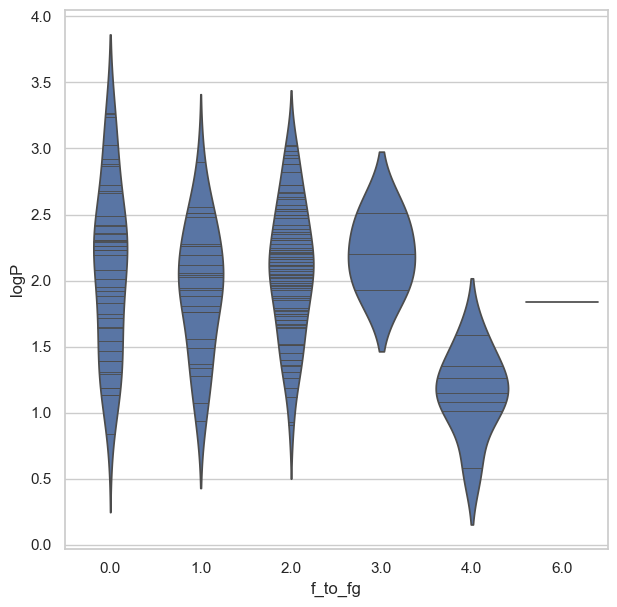

Amount of feature: angle_R1X1R2: 103
R^2 score: 0.11449287791547469
{'mse': 757.224, 'mae': 22.941, 'r_score': 0.114}


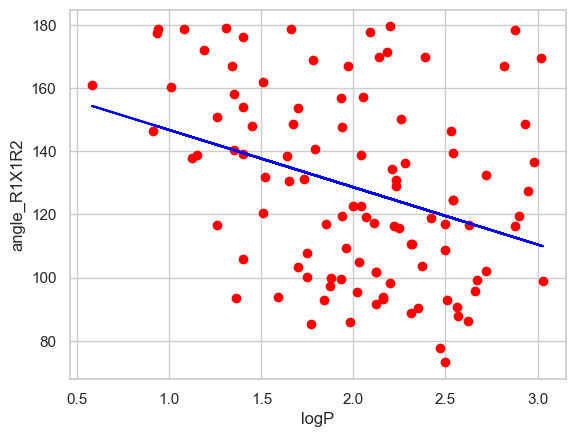

Amount of feature: angle_X2X1R1: 103
R^2 score: 0.25710357026862957
{'mse': 347.731, 'mae': 15.24, 'r_score': 0.257}


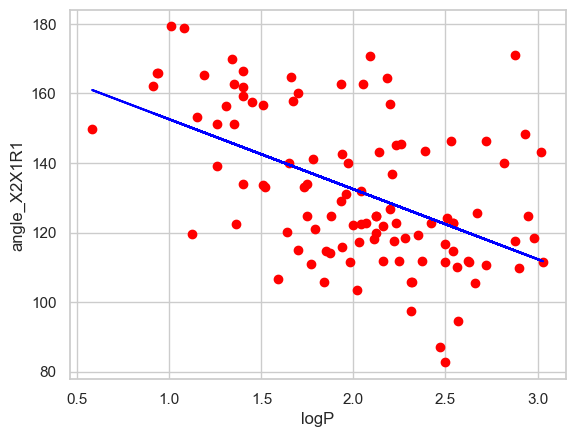

Amount of feature: nF: 5
Kruskal for nF: 26.90
P-value: 0.0000
There is a statistically significant difference between the groups


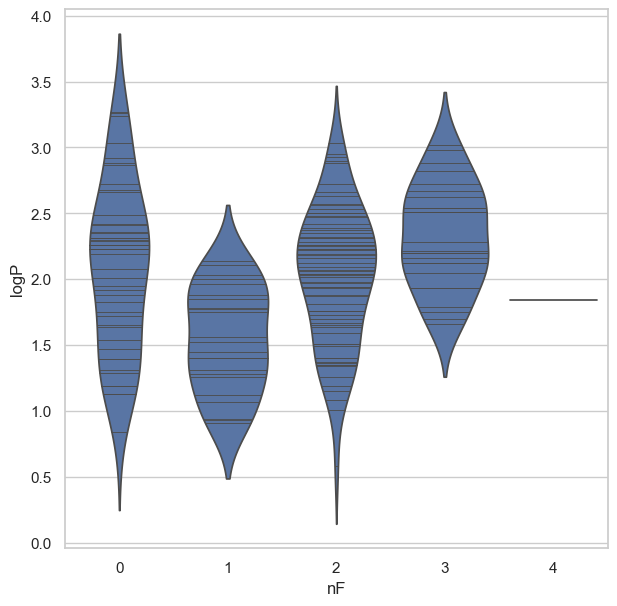

Amount of feature: FPSA3: 164
R^2 score: 0.3316989826136607
{'mse': 0.0, 'mae': 0.002, 'r_score': 0.332}


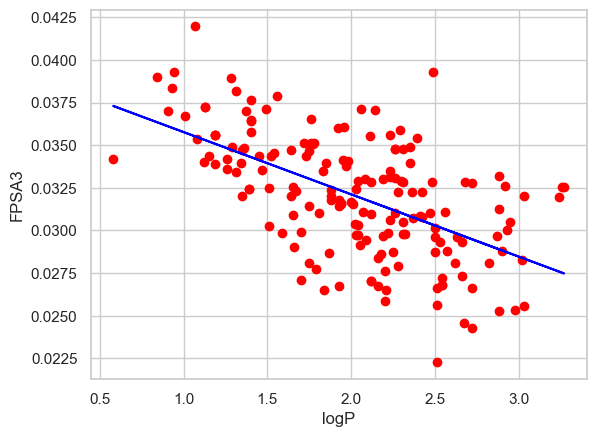

Amount of feature: mol_weight: 68
R^2 score: 0.32906312917450203
{'mse': 605.547, 'mae': 19.291, 'r_score': 0.329}


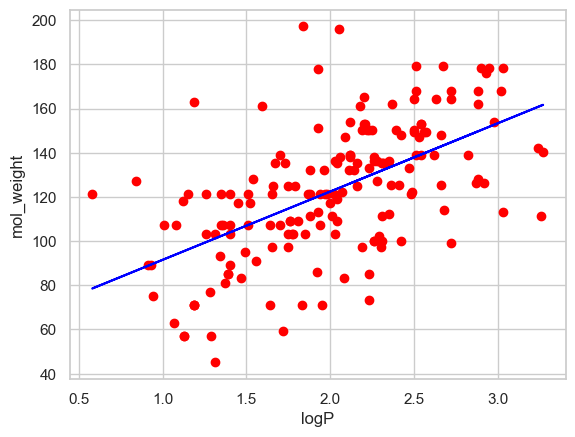

Amount of feature: RPCS: 140
R^2 score: 0.19077290014208123
{'mse': 201.3, 'mae': 12.097, 'r_score': 0.191}


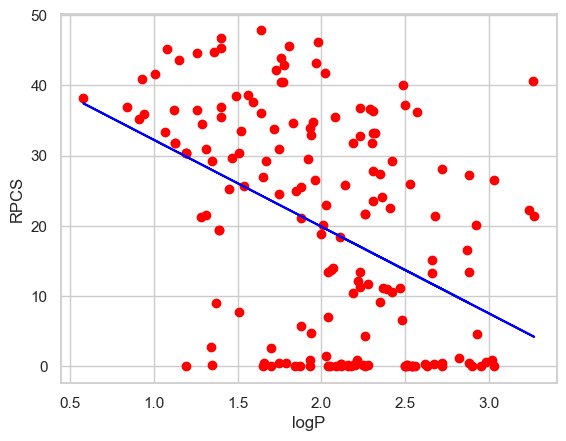

Amount of feature: mol_volume: 163
R^2 score: 0.2536397889641837
{'mse': 275.017, 'mae': 12.69, 'r_score': 0.254}


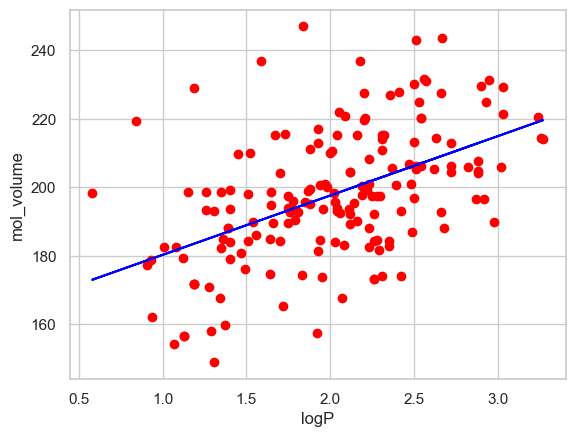

Amount of feature: TASA: 164
R^2 score: 0.3348636575053369
{'mse': 1064.575, 'mae': 26.987, 'r_score': 0.335}


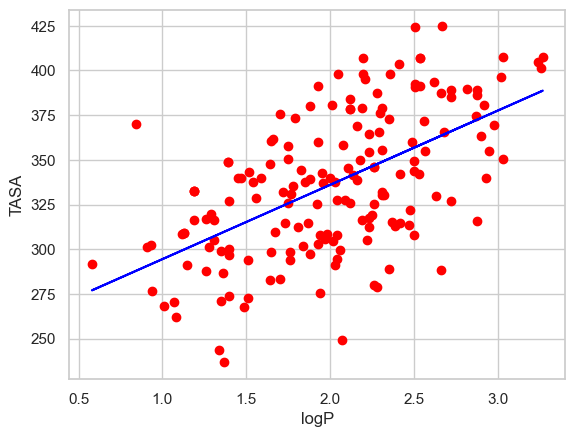

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 5210.50
P-value: 0.0000
There is a statistically significant difference between the groups


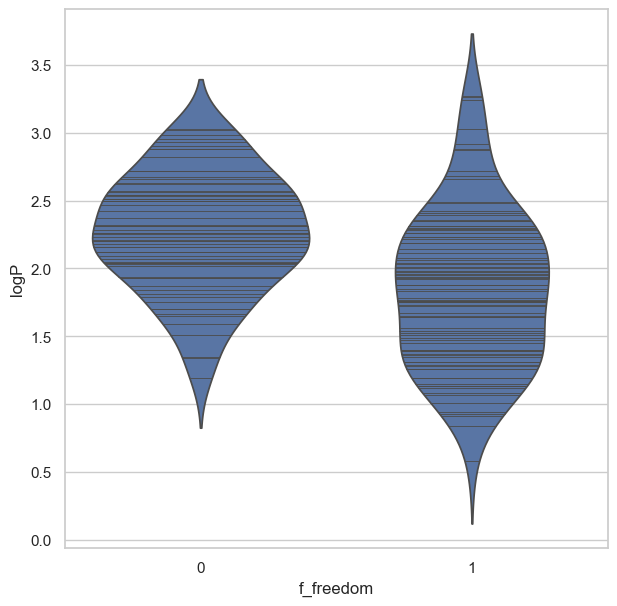

Amount of feature: mol_num_cycles: 4
Kruskal for mol_num_cycles: 11.73
P-value: 0.0084
There is a statistically significant difference between the groups


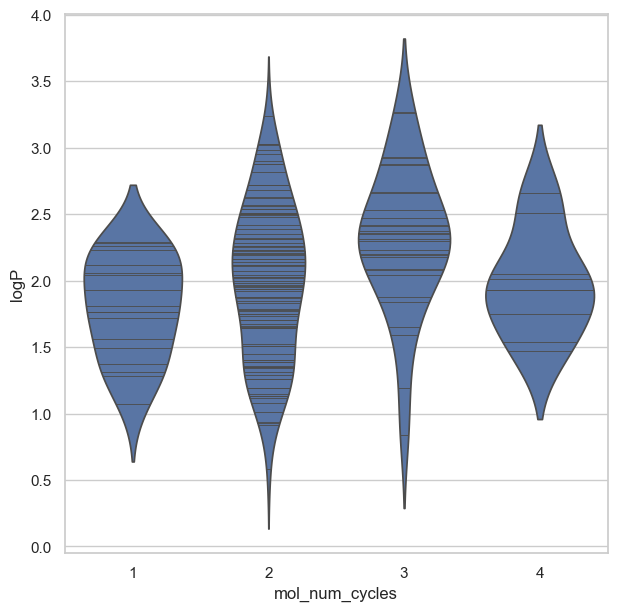

Amount of feature: nHRing: 3
Kruskal for nHRing: 44.29
P-value: 0.0000
There is a statistically significant difference between the groups


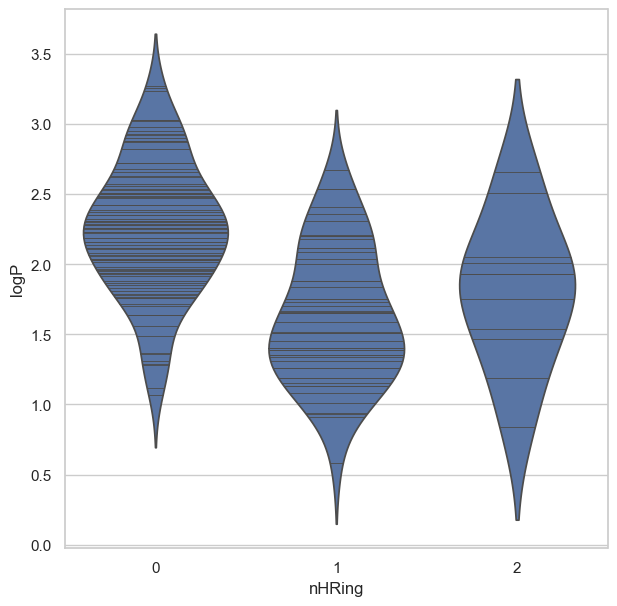

Amount of feature: nARing: 4
Kruskal for nARing: 10.93
P-value: 0.0121
There is a statistically significant difference between the groups


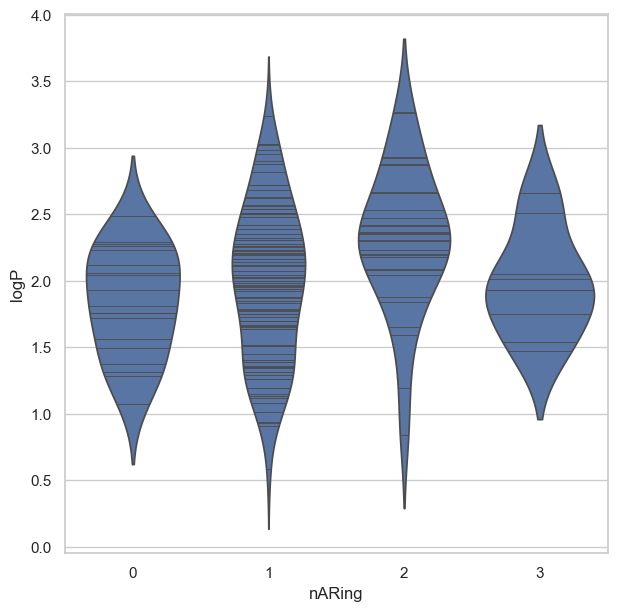

Amount of feature: mol_volume: 163
R^2 score: 0.2536397889641837
{'mse': 275.017, 'mae': 12.69, 'r_score': 0.254}


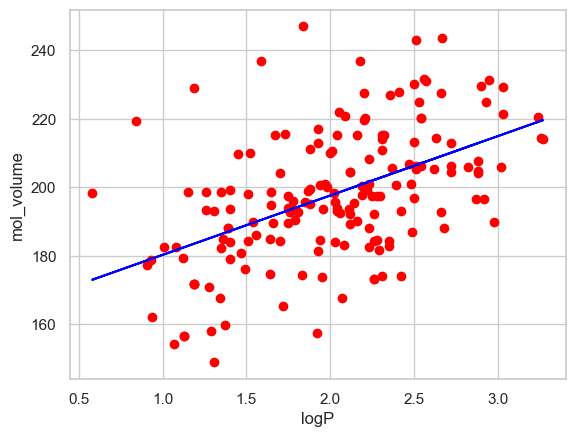

Amount of feature: nC: 7
Kruskal for nC: 44.17
P-value: 0.0000
There is a statistically significant difference between the groups


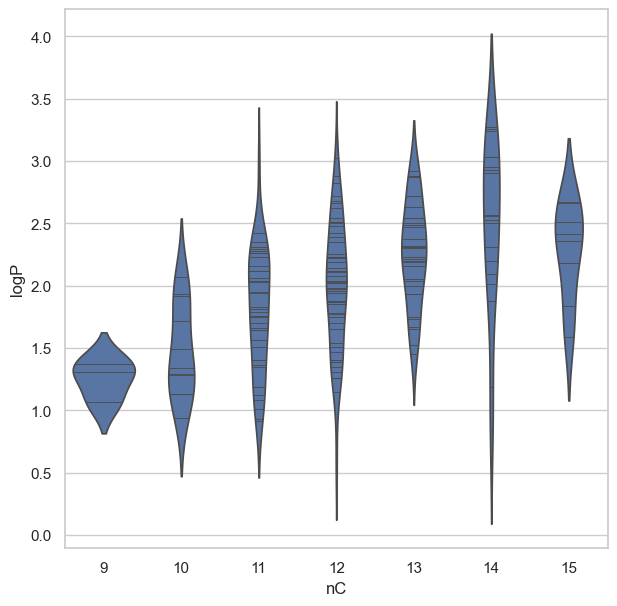

Amount of feature: nHRing: 3
Kruskal for nHRing: 44.29
P-value: 0.0000
There is a statistically significant difference between the groups


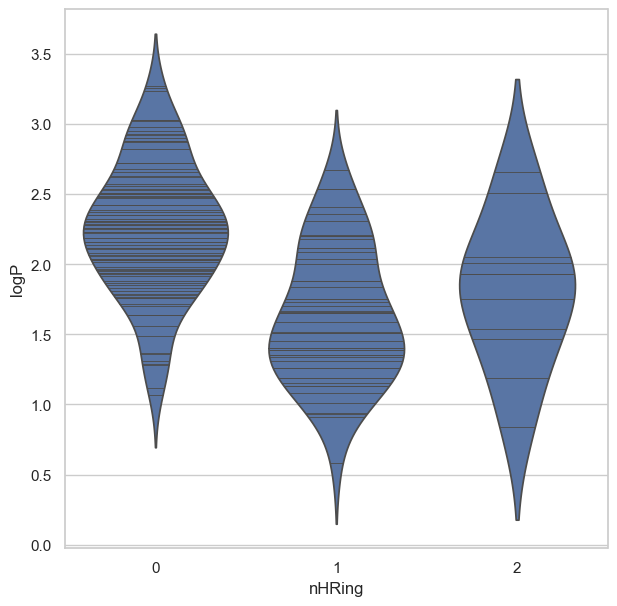

Amount of feature: WPSA5: 164
R^2 score: 0.3103017275281982
{'mse': 0.359, 'mae': 0.482, 'r_score': 0.31}


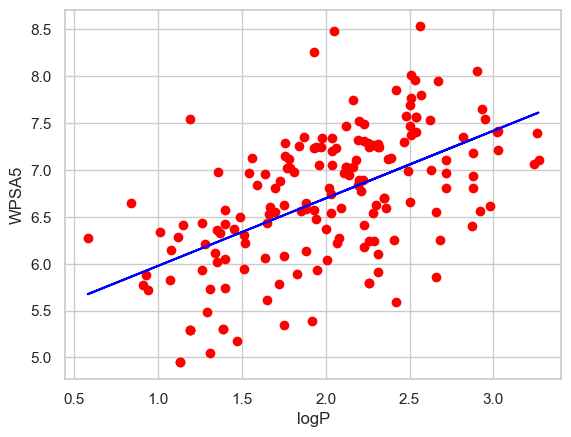

Amount of feature: PPSA5: 164
R^2 score: 0.1367320303073437
{'mse': 1.115, 'mae': 0.863, 'r_score': 0.137}


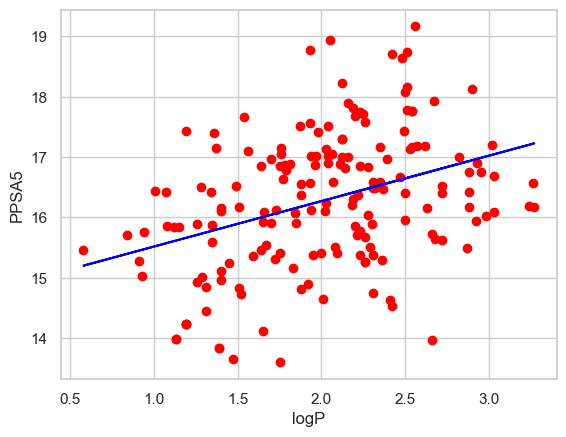

Amount of feature: identificator: 3
Kruskal for identificator: 54.73
P-value: 0.0000
There is a statistically significant difference between the groups


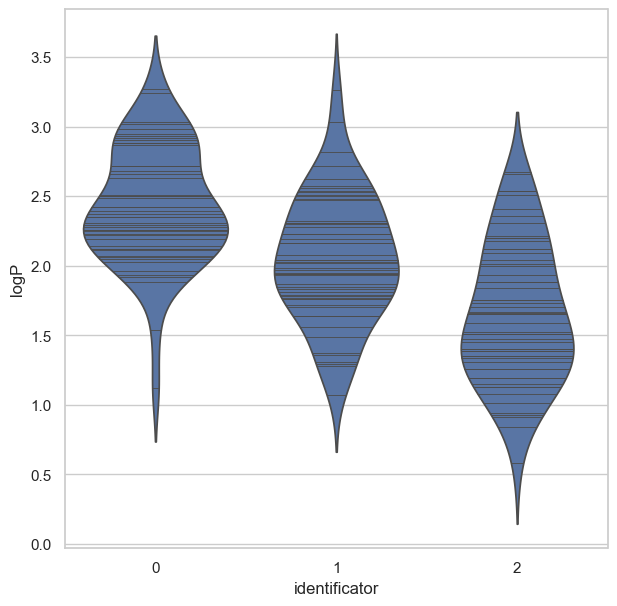

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")

    return result.pvalue


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")
    
    return result.pvalue


feature_names = df_features.columns
feature_names = ['mol_num_cycles', 'FPSA3', 'nO','mol_weight','nHRing',
                 'WPSA5', 'PBF', 'f_to_fg', 'angle_R1X1R2', 'angle_X2X1R1', 
                 'RPCS', 'nARing', 'PPSA5', 'nF', 'identificator', 'mol_volume',
                 'nC', 'chirality', 'TASA', 'f_freedom']
feature_names.append('logP')
remained_features = set()

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.5:
            continue

        if feature_names[feature_index] == 'logP':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['logP'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            r_2 = pow(r, 2)
            if r_2 > 0.1:
                remained_features.add(feature_name)
                
            print(f"R^2 score: {r_2}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('logP')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['logP']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['logP']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['logP']
                pvalue = complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                pvalue = complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            if pvalue < 0.05:
                remained_features.add(feature_name)
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='logP',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                
